In [71]:
import pandas as pd
import mplfinance as mpf
from pandas_datareader import data as pdr

In [72]:
start = "2021-02-24"
end = "2022-03-04"
symbols = ["AAPL"]

In [73]:
aapl_df = pdr.get_data_yahoo(symbols, start, end)
aapl_df.columns = [name[0] for name in aapl_df.columns]
aapl_df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [74]:
aapl_df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2021-02-24,124.609375,125.349998,125.559998,122.230003,124.940002,111039900.0
2021-02-25,120.275139,120.989998,126.459999,120.540001,124.680000,148199500.0
2021-02-26,120.543556,121.260002,124.849998,121.199997,122.589996,164560400.0
2021-03-01,127.034966,127.790001,127.930000,122.790001,123.750000,116307900.0
2021-03-02,124.380745,125.120003,128.720001,125.010002,128.410004,102260900.0


In [56]:
mpf.plot(aapl_df, figscale=2, type='candle', volume=True, savefig="AAPL_Chart.png")

In [57]:
aapl_df.to_csv('aapl_df.csv')

In [58]:
def mm_sr(dataframe):
    """Function to get max min for support and resistance"""
    n = 5
    dataframe['min_sr'] = dataframe.iloc[argrelextrema(dataframe.Close.values, np.less_equal, order=n)[0]]['Close']
    dataframe['max_sr'] = dataframe.iloc[argrelextrema(dataframe.Close.values, np.greater_equal, order=n)[0]]['Close']
    return dataframe

In [59]:
def mm_sr(dataframe):
    """Function to get max min for chart patterns"""  
    dataframe['min'] = dataframe.Close[(dataframe.Close.shift(1) > dataframe.Close) & (dataframe.Close.shift(-1) > dataframe.Close)]
    dataframe['max'] = dataframe.Close[(dataframe.Close.shift(1) < dataframe.Close) & (dataframe.Close.shift(-1) < dataframe.Close)] 
    return dataframe

In [60]:
def levels(df, sensitivity=3, tests=3, noise_r=0.01):
    # Get list of all minimum and maximum levels
    df['min'] = df.Close[(df.Close.shift(1) > df.Close) & (df.Close.shift(-1) > df.Close)]
    df['max'] = df.Close[(df.Close.shift(1) < df.Close) & (df.Close.shift(-1) < df.Close)]
    max_sr = [(row.Date, row.max) for row in df.itertuples() if row.max > 0]
    min_sr = [(row.Date, row.min) for row in df.itertuples() if row.min > 0]
    sr = sorted([[mx for mx in max_sr]+[mn for mn in min_sr]][0])
    
    # Init dictionary to store level strength
    sr_dict = {}
    
    # itereate through rows to establish and test levels
    for row in df.itertuples():
        body = abs(row.Close - row.Open)
        wick = abs(row.High - row.Low)
        candle_ratio = body/wick
        for point in sr:
            price = point[1]
            date = point[0]
            if price in sr_dict and row.Date > date:

                    
                # Close bullish inside and wick above
                if (row.Close >= (price-sensitivity) and row.Close <= (price+sensitivity)) and candle_ratio > 0.5:
                    sr_dict[price] += 1

                    
            else:
                sr_dict[price] = 0
    
    # Filter dictionary to only store levels that have been tested
    sr_dict = dict(filter(lambda val: val[1] >= tests, sr_dict.items()))
    
    # Filters strength dictionary to only include levels above a strength level
    sr = sorted([level for level, strength in sr_dict.items() if strength >= tests])
    
    # Conduct noise reduction using noise_reduction parameter
    sr_df = pd.DataFrame(sr, columns=["lvl"])
    sr_df["lvl p"] = sr_df.pct_change()

    # Filter noise
    sr = [sr_df.iloc[row[0]]['lvl'] for row in sr_df.itertuples() if row[0] > 0 if abs(row[2]) > noise_r]
    
    # Filter dictionary with values from list
    sr_dict = {key:sr_dict[key] for key in sr if key in sr_dict.keys()}
    
    # Return the levels and their strengths as a list and dictionary
    return sr, sr_dict

In [62]:
data = aapl_df.reset_index()

In [63]:
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-02-24,124.609383,125.349998,125.559998,122.230003,124.940002,111039900.0
1,2021-02-25,120.275146,120.989998,126.459999,120.540001,124.680000,148199500.0
2,2021-02-26,120.543549,121.260002,124.849998,121.199997,122.589996,164560400.0
3,2021-03-01,127.034973,127.790001,127.930000,122.790001,123.750000,116307900.0
4,2021-03-02,124.380737,125.120003,128.720001,125.010002,128.410004,102260900.0


In [66]:
sr, sr_dict = levels(data, sensitivity=.5)

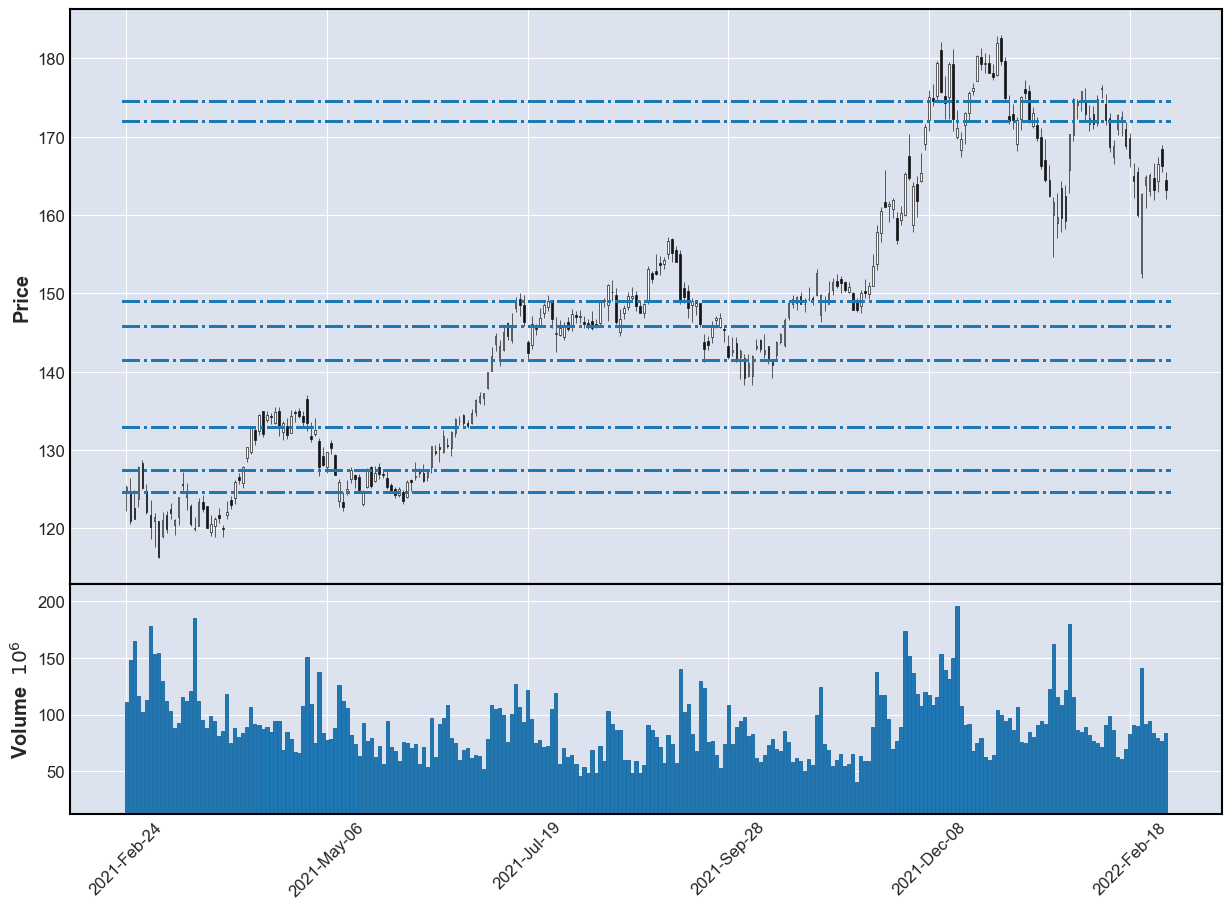

In [70]:
data = data.set_index(pd.to_datetime(data.Date))
mpf.plot(data,hlines=dict(hlines=sr,linestyle='-.'), volume=True, type='candle', figscale=2)